In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Dataset & Data loader

In [ ]:
train_dataset = datasets.MNIST('MNIST/',
                              train=True,
                              download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

test_dataset = datasets.MNIST('MNIST/',
                              train=False,
                              download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False)

### visualize the dataset

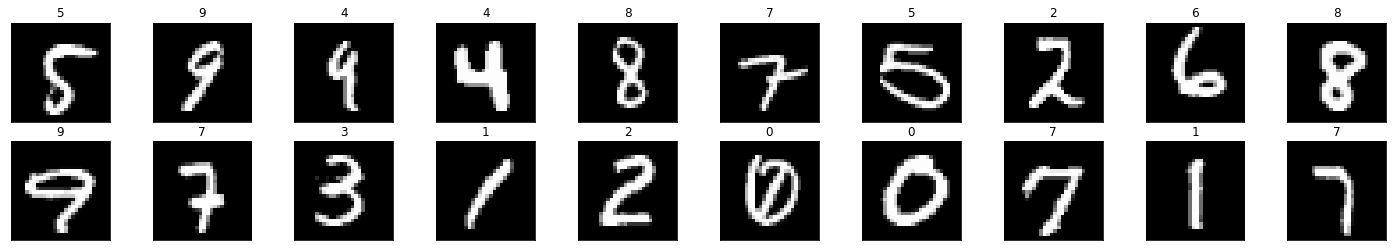

In [6]:
idx2lbl={0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9'}


images,labels=next(iter(train_loader))
fig=plt.figure(figsize=(25,4))
for i in range(1,21):
    ax=fig.add_subplot(2,10,i,xticks=[],yticks=[])
    ax.imshow(images[i].view(28,28),cmap='gray')
    ax.set_title(str(idx2lbl[labels[i].item()]))


### Model

In [7]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, input_size, output_size, hidden_size0, hidden_size1):
        super().__init__()
        self.d1 = nn.Linear(input_size,hidden_size0)  #hidden layer 1
        self.d2 = nn.Linear(hidden_size0,hidden_size1)   # hidden layer 2
        self.d3 = nn.Linear(hidden_size1,output_size)  # output layer
    
    def forward(self,X):
        X = F.relu(self.d1(X))
        X = F.relu(self.d2(X))
        X = self.d3(X)
        return F.log_softmax(X, dim=1)

In [8]:
model = MultilayerPerceptron(input_size=784, hidden_size0=120, hidden_size1=84, output_size=10).to(device)
print(model)

MultilayerPerceptron(
  (d1): Linear(in_features=784, out_features=120, bias=True)
  (d2): Linear(in_features=120, out_features=84, bias=True)
  (d3): Linear(in_features=84, out_features=10, bias=True)
)


### Optimizer and loss

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train

In [10]:
epochs = 10

for epoch in range(1,epochs+1):
    print("EPOCH:",epoch,end=" ")
    running_loss=0
    running_acc=0
    
    for images,labels in train_loader:
        images,labels=images.to(device),labels.to(device)
        X=images.view(-1,784)
        
        optimizer.zero_grad()
        output=model.forward(X)
        loss=criterion(output,labels)
        
        result=torch.argmax(output,dim=1)
        running_loss+=loss.item()
        running_acc+=torch.mean((result==labels).type(torch.float))
        
        loss.backward()
        optimizer.step()
    else:
        train_loss=running_loss/len(train_loader)
        train_acc=running_acc/len(train_loader)
        
        print("Training Loss: {:.3f}".format(train_loss),end=" ") 
       
        print("Train Accuracy: {:.2f}%".format(train_acc.item()*100))
        

EPOCH: 1 Training Loss: 0.419 Train Accuracy: 87.74%
EPOCH: 2 Training Loss: 0.203 Train Accuracy: 93.96%
EPOCH: 3 Training Loss: 0.149 Train Accuracy: 95.55%
EPOCH: 4 Training Loss: 0.118 Train Accuracy: 96.39%
EPOCH: 5 Training Loss: 0.101 Train Accuracy: 96.89%
EPOCH: 6 Training Loss: 0.084 Train Accuracy: 97.40%
EPOCH: 7 Training Loss: 0.076 Train Accuracy: 97.65%
EPOCH: 8 Training Loss: 0.068 Train Accuracy: 97.77%
EPOCH: 9 Training Loss: 0.061 Train Accuracy: 98.02%
EPOCH: 10 Training Loss: 0.054 Train Accuracy: 98.26%


### Test

In [11]:
tst_corr = 0

with torch.no_grad(): 
    for b, (X_test, y_test) in enumerate(test_loader):
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = model(X_test.view(-1,784)) 
 
        predicted = torch.max(y_val.data, 1)[1] 
        tst_corr += (predicted == y_test).sum()
    
print(f'Test accuracy: {tst_corr*100/10000:.3f}%') 

Test accuracy: 97.640%
